# Download dependencies and data

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!kaggle datasets download -d kmader/parkinsons-drawings

Dataset URL: https://www.kaggle.com/datasets/kmader/parkinsons-drawings
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
parkinsons-drawings.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile

file_path = '/content/parkinsons-drawings.zip'

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/kaggle')


# Imports and local API

In [ ]:
import numpy as np
import glob
import cv2
import ntpath
import matplotlib.pyplot as plt
import random
import time

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, AveragePooling2D
from tensorflow.keras.layers import Concatenate, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121, ResNet50, VGG16

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle

# Verificando se a GPU está ativa
print('GPUs available:',len(tf.config.list_physical_devices('GPU')))

GPUs available: 1


## Funções de manipulação dos dados

In [ ]:
from typing import Tuple

def baseDir(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)


def loadData(X_data, y_data, path):
  files = glob.glob(f"{path}/*.png")
  dirname = baseDir(path)

  for img in files:
    # print(myFile)
    image = cv2.imread(img)
    X_data.append(image)
    if dirname == 'healthy': y_data.append(0)
    else: y_data.append(1)

  return X_data, y_data

## Funções de formatação de dados

In [ ]:
def resize_with_padding(data, exp_shape):
  for i in range(len(data)):
    img = data[i]
    img_shape = [img.shape[1], img.shape[0]]
    if img_shape != exp_shape:
      ratio = max(exp_shape)/max(img_shape)
      new_size = tuple([int(x*ratio) for x in img_shape])
      img = cv2.resize(img, new_size)
      delta_w = exp_shape[0] - new_size[0]
      delta_h = exp_shape[1] - new_size[1]
      top, bottom = delta_h//2, delta_h-(delta_h//2)
      left, right = delta_w//2, delta_w-(delta_w//2)
      img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(255,255,255))
      data[i] = img

  return data


def resize(data, exp_shape):
  for img in data:
    if img.shape != exp_shape:
      img = cv2.resize(img, exp_shape, interpolation=cv2.INTER_AREA)

  return data


def segment(data):
  for n in range(len(data)):
    img = data[n]
    tresh = np.percentile(img, 5)

    for i in range(len(img)):
      for j in range(len(img[0])):
        for c in range(len(img[0][0])):
          if img[i][j][c] < tresh:
            img[i][j][c] = 0
          else:
            img[i][j][c] = 255
          data[n] = img

  data = resize_with_padding(data, [256,256])

  return data

## Funções de data augmentation

In [ ]:
def augment(data, label):
  for n in range(len(data)):
    img = data[n]
    data.append(cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE))
    label.append(label[n])
    data.append(cv2.rotate(img, cv2.ROTATE_180))
    label.append(label[n])
    data.append(cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE))
    label.append(label[n])
    flip = cv2.flip(img, 1)
    data.append(flip)
    label.append(label[n])
    data.append(cv2.rotate(flip, cv2.ROTATE_90_CLOCKWISE))
    label.append(label[n])
    data.append(cv2.rotate(flip, cv2.ROTATE_180))
    label.append(label[n])
    data.append(cv2.rotate(flip, cv2.ROTATE_90_COUNTERCLOCKWISE))
    label.append(label[n])

  return data, label

## Funções de plot

In [ ]:
def countClasses(data, classes):
  cnt = []
  for i in range(len(classes)):
    cnt.append(data.count(classes[i]))

  return cnt


def plotSamples(data, title):
  x = 0; y = 0
  samp = random.sample(data, 5)
  fig1, axs1 = plt.subplots(nrows=1, ncols=5)
  fig1.suptitle(title, y=0.65)
  for img in samp:
    axs1[x].imshow(img)
    axs1[x].axis('off')
    x = x+1
  samp = random.sample(data, 5)
  fig2, axs2 = plt.subplots(nrows=1, ncols=5)
  for img in samp:
    axs2[y].imshow(img)
    axs2[y].axis('off')
    y = y+1
  plt.show()


def plotSamplesGray(data, title):
  x = 0; y = 0
  samp = random.sample(data, 5)
  fig1, axs1 = plt.subplots(nrows=1, ncols=5)
  fig1.suptitle(title, y=0.65)
  for img in samp:
    axs1[x].imshow(img, cmap='gray')
    axs1[x].axis('off')
    x = x+1
  samp = random.sample(data, 5)
  fig2, axs2 = plt.subplots(nrows=1, ncols=5)
  for img in samp:
    axs2[y].imshow(img, cmap='gray')
    axs2[y].axis('off')
    y = y+1
  plt.show()

## Funções de inferência dos modelos

In [ ]:
# Função de treino dos modelos de deep learning
def train_dl_model(model, name, train_X, train_y):

  # Callback para salvar o melhor modelo durante o treinamento
  checkpoint = callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', verbose=1)

  # Treinamento do modelo
  start_time = time.time()
  history = model.fit(
    train_X, train_y,
    epochs=30,
    shuffle=True,
    validation_split=1/5,
    callbacks=[checkpoint]
  )
  end_time = time.time()

  # Calcular tempo de execução
  exec_time = end_time - start_time
  print(f'\nTempo de execução do {name} em segundos: {np.round(exec_time,2)}')

  # Plotar gráfico de acurácia durante o treino
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  ax = plt.gca()
  ax.set_ylim([0,1])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['Train', 'Validation'])
  plt.show()

  # Plotar gráfico de custo durante o treino
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  ax = plt.gca()
  ax.set_ylim([0,1])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Train', 'Validation'])
  plt.show()

  # Salvando os dados do modelo
  model_list.append(name)
  exec_times.append(np.round(exec_time,2))


# Função de avaliação de modelos deep learning
def evaluate_dl_model(model, name, test_X, test_y, labels):

  # Avaliação do modelo no conjunto de teste
  test_loss, test_acc = model.evaluate(test_X, test_y)
  print(f'{name} Test Accuracy: {np.round(test_acc,4)}, {name} Test Loss: {np.round(test_loss,4)}\n')

  # Fazendo a classificação do conjunto de testes
  pred_y = np.argmax(model.predict(test_X), axis=1)

  # Medindo a acurácia do modelo
  accuracy = accuracy_score(test_y, pred_y)

  # Relatório de classificação do modelo
  print(f"\nClassification Report do {name}")
  print(classification_report(test_y, pred_y))

  # Definindo a matriz de confusão
  cm = confusion_matrix(test_y, pred_y)

  # Calculando a TPR
  TPR = cm.diagonal()/cm.sum(axis=1)
  print(f'\nTPR por classe do {name}:',np.round(TPR,4))

  # Exibindo a matriz de confusão
  print('\nConfusion Matrix')
  ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot();

  # Adicionando os dados do modelo aos vetores de resultado
  accuracies.append(np.round(accuracy,4))

## Variáveis globais

In [ ]:
# Predefinindo arrays de resultado
model_list = []
exec_times = []
accuracies = []
datasets = ['rgb_pd','rgb_rs','gray_pd','gray_rs','seg']
labels = ['healthy', 'parkinson']

# Processing data

In [ ]:
X_train = []; X_test = []
y_train = []; y_test = []

X_train, y_train = loadData(X_train, y_train, "/content/drive/MyDrive/kaggle/spiral/training/healthy")
X_train, y_train = loadData(X_train, y_train, "/content/drive/MyDrive/kaggle/spiral/training/parkinson")
X_train, y_train = loadData(X_train, y_train, "/content/drive/MyDrive/kaggle/wave/training/healthy")
X_train, y_train = loadData(X_train, y_train, "/content/drive/MyDrive/kaggle/wave/training/parkinson")

X_test, y_test = loadData(X_test, y_test, "/content/drive/MyDrive/kaggle/spiral/testing/healthy")
X_test, y_test = loadData(X_test, y_test, "/content/drive/MyDrive/kaggle/spiral/testing/parkinson")
X_test, y_test = loadData(X_test, y_test, "/content/drive/MyDrive/kaggle/wave/testing/healthy")
X_test, y_test = loadData(X_test, y_test, "/content/drive/MyDrive/kaggle/wave/testing/parkinson")

print('train data size:',len(X_train),len(y_train))
print('test data size:',len(X_test), len(y_test))

train data size: 144 144
test data size: 60 60


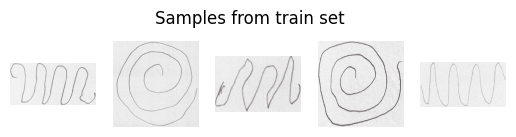

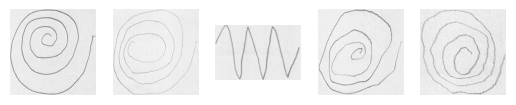

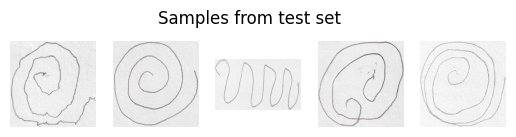

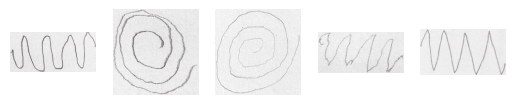

In [ ]:
title = "Samples from train set"
plotSamples(X_train, title)
title = "Samples from test set"
plotSamples(X_test, title)

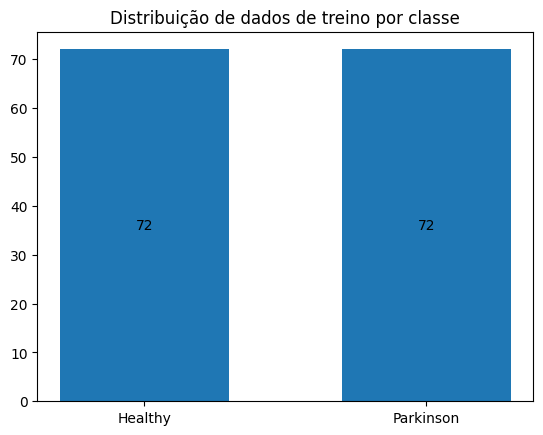

In [ ]:
dist = countClasses(y_train, [0,1])
classes = ['Healthy', 'Parkinson']

fig = plt.bar(classes, dist, width=0.6, label=classes)
plt.bar_label(fig, label_type='center')
plt.title('Distribuição de dados de treino por classe')

plt.show()

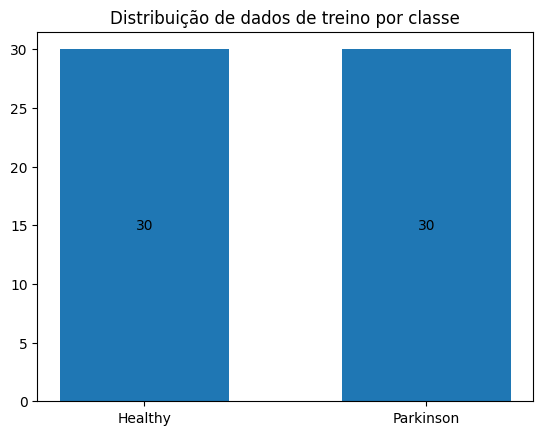

In [ ]:
dist = countClasses(y_test, [0,1])
classes = ['Healthy', 'Parkinson']

fig = plt.bar(classes, dist, width=0.6, label=classes)
plt.bar_label(fig, label_type='center')
plt.title('Distribuição de dados de treino por classe')

plt.show()

### Augmentation

In [ ]:
X_train, y_train = augment(X_train, y_train)

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

print('train data size:',len(X_train),len(y_train))

train data size: 1152 1152


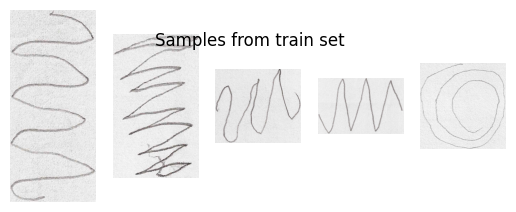

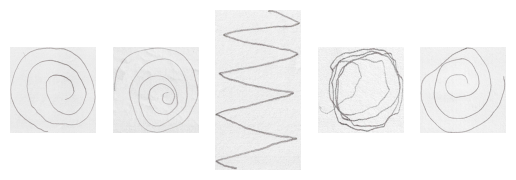

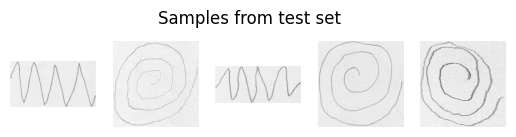

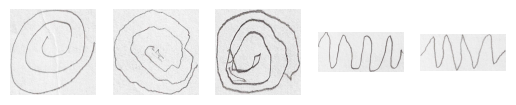

In [ ]:
title = "Samples from train set"
plotSamples(X_train, title)
title = "Samples from test set"
plotSamples(X_test, title)

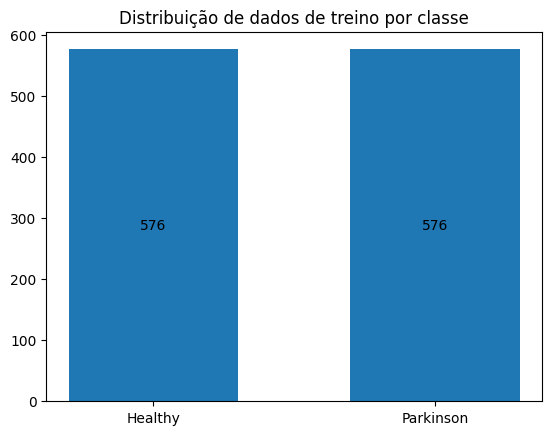

In [ ]:
dist = countClasses(y_train, [0,1])
classes = ['Healthy', 'Parkinson']

fig = plt.bar(classes, dist, width=0.6, label=classes)
plt.bar_label(fig, label_type='center')
plt.title('Distribuição de dados de treino por classe')

plt.show()

### Padding

In [ ]:
X_pd_train = resize_with_padding(X_train, [256,256])
X_pd_test = resize_with_padding(X_test, [256,256])

y_pd_train = y_train
y_pd_test = y_test

#for img in X_pd_train:
#  if img.shape != (256,256,3): print(img.shape)

print('train data size:',np.array(X_pd_train).shape)
print('test data size:',np.array(X_pd_test).shape)

train data size: (1152, 256, 256, 3)
test data size: (60, 256, 256, 3)


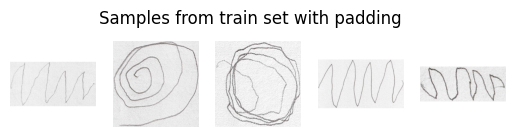

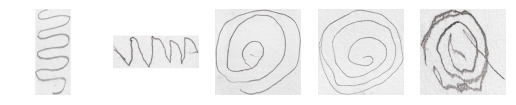

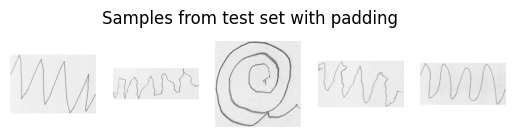

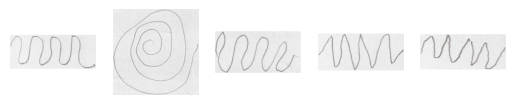

In [ ]:
title = "Samples from train set with padding"
plotSamples(X_pd_train, title)
title = "Samples from test set with padding"
plotSamples(X_pd_test, title)

In [ ]:
# Normalizando os dados# Normalizando os dados
X_pd_train = np.array(X_pd_train).astype('float32') / 255.0
X_pd_test = np.array(X_pd_test).astype('float32') / 255.0
y_pd_train = np.array(y_pd_train)
y_pd_test = np.array(y_pd_test)

### Resizing

In [ ]:
X_rs_train = resize(X_train, (256,256))
X_rs_test = resize(X_test, (256,256))

y_rs_train = y_train
y_rs_test = y_test

#for img in X_pd_train:
#  if img.shape != (256,256,3): print(img.shape)

print('train data size:',np.array(X_rs_train).shape)
print('test data size:',np.array(X_rs_test).shape)

train data size: (1152, 256, 256, 3)
test data size: (60, 256, 256, 3)


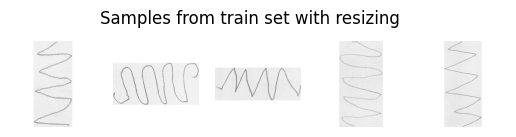

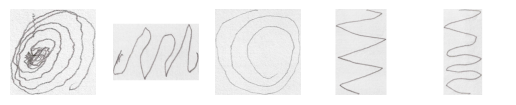

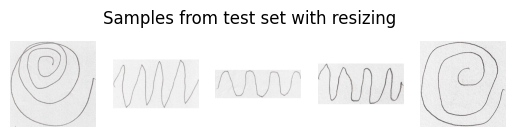

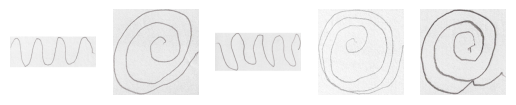

In [ ]:
title = "Samples from train set with resizing"
plotSamples(X_rs_train, title)
title = "Samples from test set with resizing"
plotSamples(X_rs_test, title)

In [ ]:
# Normalizando os dados
X_rs_train = np.array(X_rs_train).astype('float32') / 255.0
X_rs_test = np.array(X_rs_test).astype('float32') / 255.0
y_rs_train = np.array(y_rs_train)
y_rs_test = np.array(y_rs_test)

## Segmented

In [ ]:
X_gr_train = []
X_gr_test = []

for img in X_train:
  X_gr_train.append(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))

for img in X_test:
  X_gr_test.append(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))

X_gr_train = [np.stack((img,)*3, axis=-1) for img in X_gr_train]
X_gr_test = [np.stack((img,)*3, axis=-1) for img in X_gr_test]

y_gr_train = y_train
y_gr_test = y_test

print('train data size:',np.array(X_gr_train).shape,len(y_gr_train))
print('test data size:',np.array(X_gr_test).shape, len(y_gr_test))

train data size: (1152, 256, 256, 3) 1152
test data size: (60, 256, 256, 3) 60


In [ ]:
X_seg_train = segment(X_gr_train)
X_seg_test = segment(X_gr_test)

y_seg_train = y_train
y_seg_test = y_test

print('train data size:',np.array(X_seg_train).shape)
print('test data size:',np.array(X_seg_test).shape)

train data size: (1152, 256, 256, 3)
test data size: (60, 256, 256, 3)


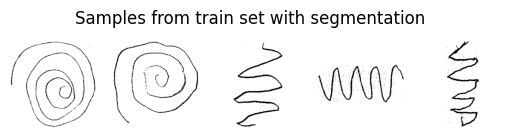

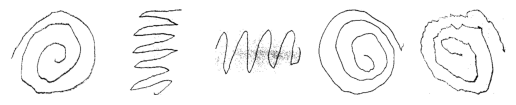

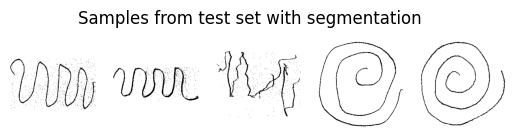

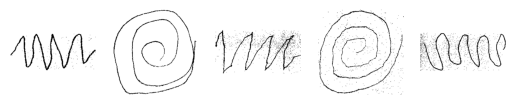

In [ ]:
title = "Samples from train set with segmentation"
plotSamplesGray(X_seg_train, title)
title = "Samples from test set with segmentation"
plotSamplesGray(X_seg_test, title)

In [ ]:
# Normalizando os dados
X_seg_train = np.array(X_seg_train).astype('float32') / 255.0
X_seg_test = np.array(X_seg_test).astype('float32') / 255.0
y_seg_train = np.array(y_seg_train)
y_seg_test = np.array(y_seg_test)

#DenseNet


In [ ]:
name = 'DenseNet'

# Configurando o modelo base
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = True  # Descongelar todas as camadas para treinamento

# Construção do novo modelo para o novo conjunto de classes
modelDenseNet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # Adaptar para o número de classes correto
])

# Compilar o modelo com as configurações de otimização e perda
modelDenseNet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
modelDenseNet.save_weights('densenet.h5')

## Inference

### Padded RGB

Epoch 1/30
29/29 [==============================] - ETA: 0s - loss: 0.6910 - accuracy: 0.7438
Epoch 1: val_accuracy improved from -inf to 0.54113, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 73s 624ms/step - loss: 0.6910 - accuracy: 0.7438 - val_loss: 0.8225 - val_accuracy: 0.5411
Epoch 2/30
29/29 [==============================] - ETA: 0s - loss: 0.4244 - accuracy: 0.8350
Epoch 2: val_accuracy improved from 0.54113 to 0.55844, saving model to best_model.h5
29/29 [==============================] - 15s 502ms/step - loss: 0.4244 - accuracy: 0.8350 - val_loss: 1.9252 - val_accuracy: 0.5584
Epoch 3/30
29/29 [==============================] - ETA: 0s - loss: 0.2689 - accuracy: 0.8882
Epoch 3: val_accuracy did not improve from 0.55844
29/29 [==============================] - 13s 450ms/step - loss: 0.2689 - accuracy: 0.8882 - val_loss: 5.5988 - val_accuracy: 0.5065
Epoch 4/30
29/29 [==============================] - ETA: 0s - loss: 0.2214 - accuracy: 0.9012
Epoch 4: val_accuracy did not improve from 0.55844
29/29 [==============================] - 13s 449ms/step - loss: 0.2214 - accuracy: 0.9012 - val_loss: 3.7176 - val_accuracy: 0.5325
Ep

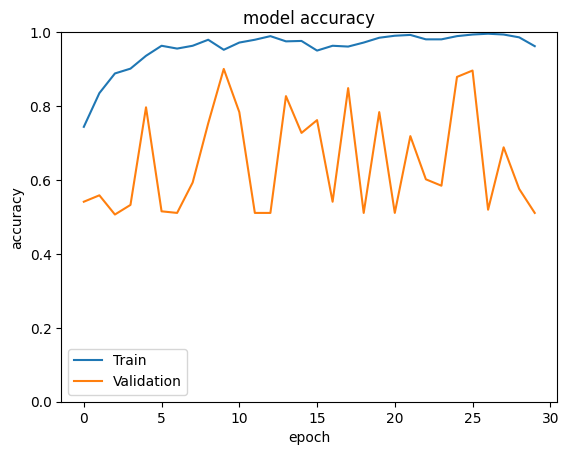

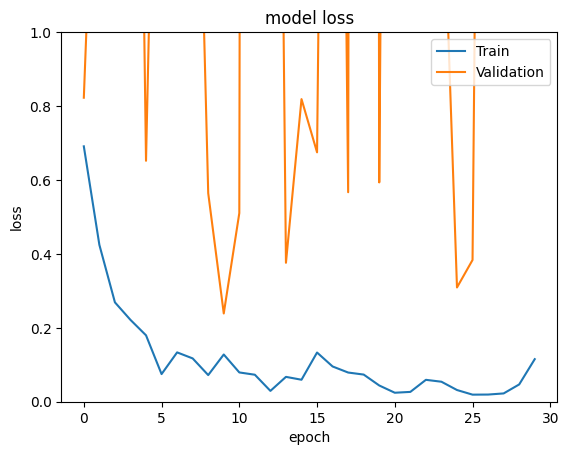

In [ ]:
train_dl_model(modelDenseNet, name, X_pd_train, y_pd_train)

2/2 [==============================] - 0s 125ms/step - loss: 0.3221 - accuracy: 0.8500
DenseNet Test Accuracy: 0.85, DenseNet Test Loss: 0.3221

2/2 [==============================] - 2s 148ms/step

Classification Report do DenseNet
              precision    recall  f1-score   support

           0       0.84      0.87      0.85        30
           1       0.86      0.83      0.85        30

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60


TPR por classe do DenseNet: [0.8667 0.8333]

Confusion Matrix


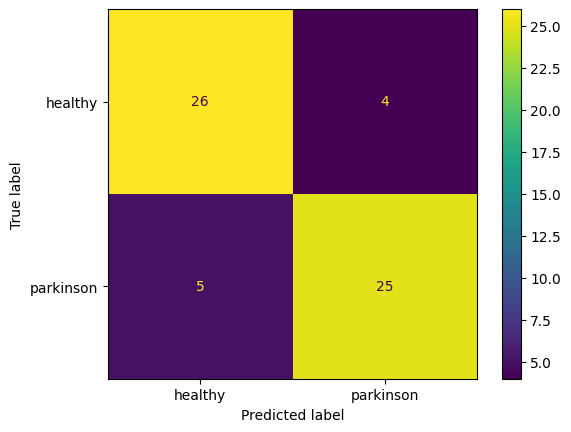

In [ ]:
modelDenseNet.load_weights('best_model.h5')
evaluate_dl_model(modelDenseNet, name, X_pd_test, y_pd_test, labels)

In [ ]:
modelDenseNet.load_weights('densenet.h5')

### Resized RGB

Epoch 1/30
29/29 [==============================] - ETA: 0s - loss: 0.8426 - accuracy: 0.6797
Epoch 1: val_accuracy improved from -inf to 0.51082, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 15s 504ms/step - loss: 0.8426 - accuracy: 0.6797 - val_loss: 173179808.0000 - val_accuracy: 0.5108
Epoch 2/30
29/29 [==============================] - ETA: 0s - loss: 0.4906 - accuracy: 0.7883
Epoch 2: val_accuracy did not improve from 0.51082
29/29 [==============================] - 13s 454ms/step - loss: 0.4906 - accuracy: 0.7883 - val_loss: 74836.6953 - val_accuracy: 0.4892
Epoch 3/30
29/29 [==============================] - ETA: 0s - loss: 0.4221 - accuracy: 0.8284
Epoch 3: val_accuracy did not improve from 0.51082
29/29 [==============================] - 13s 454ms/step - loss: 0.4221 - accuracy: 0.8284 - val_loss: 91.7479 - val_accuracy: 0.5108
Epoch 4/30
29/29 [==============================] - ETA: 0s - loss: 0.3573 - accuracy: 0.8632
Epoch 4: val_accuracy did not improve from 0.51082
29/29 [==============================] - 13s 450ms/step - loss: 0.3573 - accuracy: 0.8632 - val_loss: 14.0212 - val_accuracy: 0.5108
Epoch 5/30
29/29 [=====

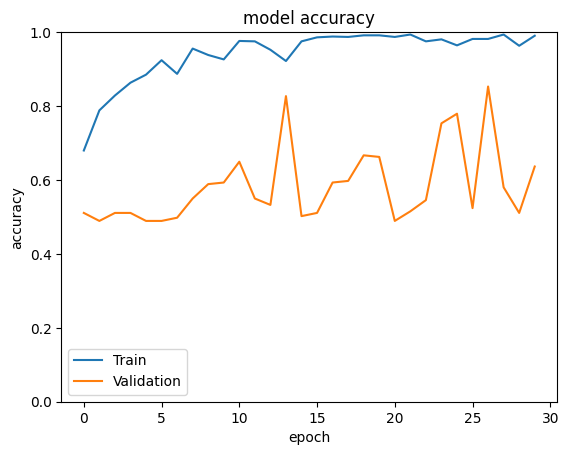

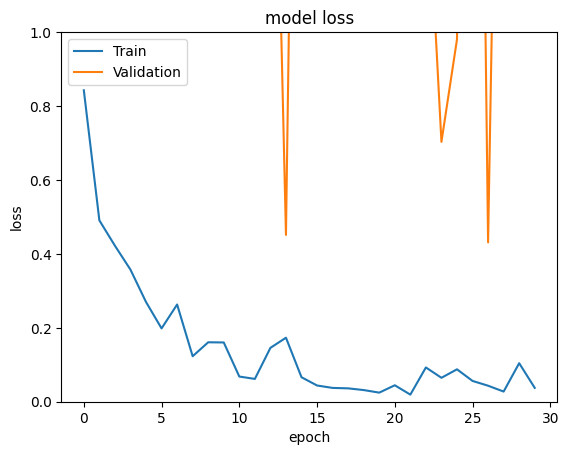

In [ ]:
train_dl_model(modelDenseNet, name, X_rs_train, y_rs_train)

2/2 [==============================] - 0s 130ms/step - loss: 1.0647 - accuracy: 0.7667
DenseNet Test Accuracy: 0.7667, DenseNet Test Loss: 1.0647

2/2 [==============================] - 0s 102ms/step

Classification Report do DenseNet
              precision    recall  f1-score   support

           0       0.77      0.77      0.77        30
           1       0.77      0.77      0.77        30

    accuracy                           0.77        60
   macro avg       0.77      0.77      0.77        60
weighted avg       0.77      0.77      0.77        60


TPR por classe do DenseNet: [0.7667 0.7667]

Confusion Matrix


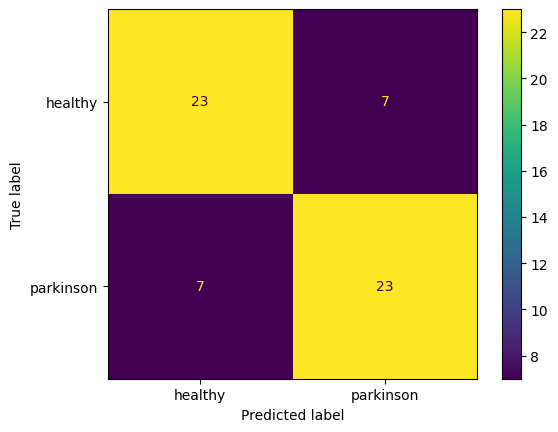

In [ ]:
modelDenseNet.load_weights('best_model.h5')
evaluate_dl_model(modelDenseNet, name, X_rs_test, y_rs_test, labels)

In [ ]:
modelDenseNet.load_weights('densenet.h5')

### Segmented

Epoch 1/30
29/29 [==============================] - ETA: 0s - loss: 0.9827 - accuracy: 0.6145
Epoch 1: val_accuracy improved from -inf to 0.51082, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 15s 506ms/step - loss: 0.9827 - accuracy: 0.6145 - val_loss: 991866816.0000 - val_accuracy: 0.5108
Epoch 2/30
29/29 [==============================] - ETA: 0s - loss: 0.7735 - accuracy: 0.6015
Epoch 2: val_accuracy did not improve from 0.51082
29/29 [==============================] - 13s 455ms/step - loss: 0.7735 - accuracy: 0.6015 - val_loss: 1461095.7500 - val_accuracy: 0.5108
Epoch 3/30
29/29 [==============================] - ETA: 0s - loss: 0.7398 - accuracy: 0.6482
Epoch 3: val_accuracy did not improve from 0.51082
29/29 [==============================] - 13s 454ms/step - loss: 0.7398 - accuracy: 0.6482 - val_loss: 37.7855 - val_accuracy: 0.4892
Epoch 4/30
29/29 [==============================] - ETA: 0s - loss: 0.6753 - accuracy: 0.6330
Epoch 4: val_accuracy did not improve from 0.51082
29/29 [==============================] - 13s 465ms/step - loss: 0.6753 - accuracy: 0.6330 - val_loss: 3.1829 - val_accuracy: 0.4935
Epoch 5/30
29/29 [====

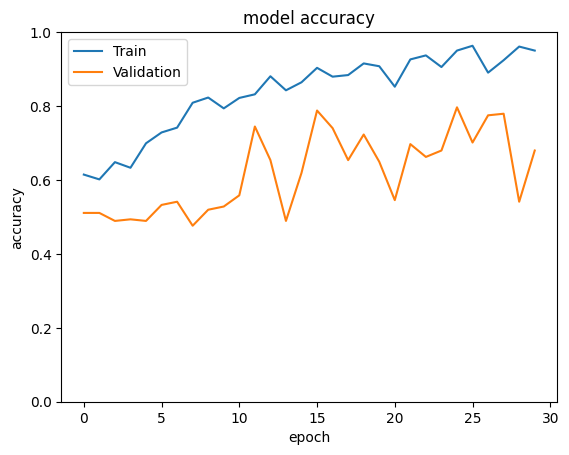

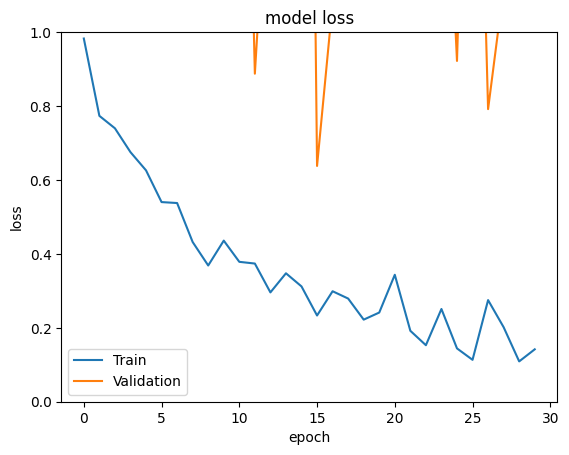

In [ ]:
train_dl_model(modelDenseNet, name, X_seg_train, y_seg_train)

2/2 [==============================] - 0s 105ms/step - loss: 0.8636 - accuracy: 0.7500
DenseNet Test Accuracy: 0.75, DenseNet Test Loss: 0.8636

2/2 [==============================] - 0s 102ms/step

Classification Report do DenseNet
              precision    recall  f1-score   support

           0       0.76      0.73      0.75        30
           1       0.74      0.77      0.75        30

    accuracy                           0.75        60
   macro avg       0.75      0.75      0.75        60
weighted avg       0.75      0.75      0.75        60


TPR por classe do DenseNet: [0.7333 0.7667]

Confusion Matrix


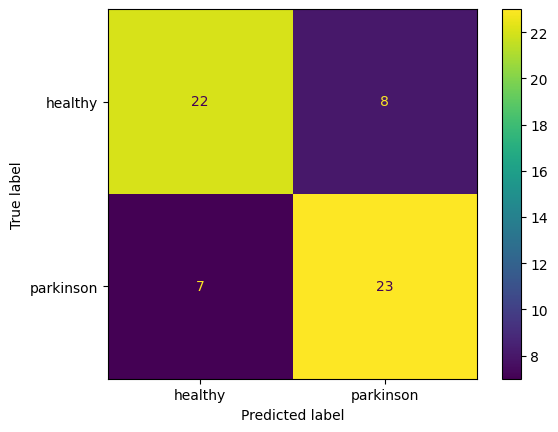

In [ ]:
modelDenseNet.load_weights('best_model.h5')
evaluate_dl_model(modelDenseNet, name, X_seg_test, y_seg_test, labels)

In [ ]:
modelDenseNet.load_weights('densenet.h5')

#ResNet


In [ ]:
name = 'ResNet'

# Configurando o modelo
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # Congelar a base do modelo

# Construção do novo modelo para o novo conjunto de classes
modelResNet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation= 'relu'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# Compilar o modelo com as configurações de otimização e perda
modelResNet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
modelResNet.save_weights('resnet.h5')

94765736/94765736 [==============================] - 1s 0us/step


## Inference

### Padded RGB

Epoch 1/30
29/29 [==============================] - ETA: 0s - loss: 2.3412 - accuracy: 0.3051
Epoch 1: val_accuracy improved from -inf to 0.03030, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 21s 354ms/step - loss: 2.3412 - accuracy: 0.3051 - val_loss: 2.2838 - val_accuracy: 0.0303
Epoch 2/30
29/29 [==============================] - ETA: 0s - loss: 1.6155 - accuracy: 0.5570
Epoch 2: val_accuracy improved from 0.03030 to 0.48918, saving model to best_model.h5
29/29 [==============================] - 5s 159ms/step - loss: 1.6155 - accuracy: 0.5570 - val_loss: 1.5652 - val_accuracy: 0.4892
Epoch 3/30
29/29 [==============================] - ETA: 0s - loss: 1.1198 - accuracy: 0.6688
Epoch 3: val_accuracy did not improve from 0.48918
29/29 [==============================] - 4s 139ms/step - loss: 1.1198 - accuracy: 0.6688 - val_loss: 1.0184 - val_accuracy: 0.4892
Epoch 4/30
29/29 [==============================] - ETA: 0s - loss: 0.8145 - accuracy: 0.6873
Epoch 4: val_accuracy improved from 0.48918 to 0.53247, saving model to best_model.h5
29/29 [==============================] - 5s 187ms/step - loss: 0.8145 - accuracy: 0.6873 - val_loss: 

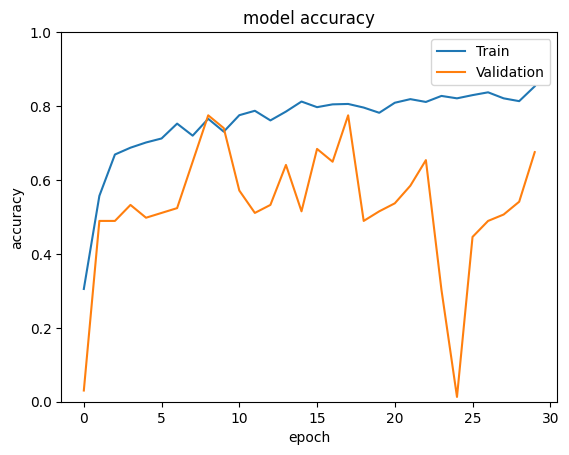

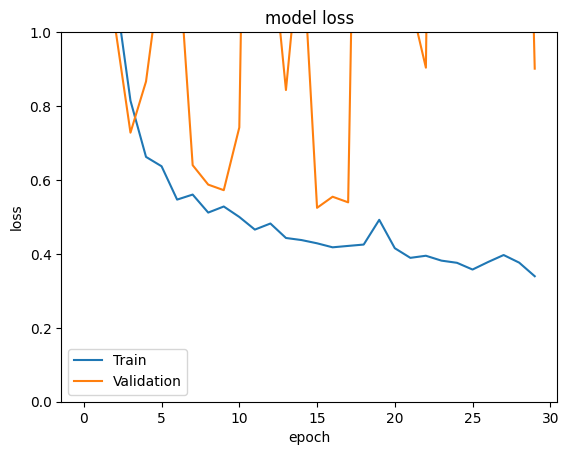

In [ ]:
train_dl_model(modelResNet, name, X_pd_train, y_pd_train)

2/2 [==============================] - 2s 2s/step - loss: 0.5781 - accuracy: 0.7333
ResNet Test Accuracy: 0.7333, ResNet Test Loss: 0.5781

2/2 [==============================] - 1s 102ms/step

Classification Report do ResNet
              precision    recall  f1-score   support

           0       0.79      0.63      0.70        30
           1       0.69      0.83      0.76        30

    accuracy                           0.73        60
   macro avg       0.74      0.73      0.73        60
weighted avg       0.74      0.73      0.73        60


TPR por classe do ResNet: [0.6333 0.8333]

Confusion Matrix


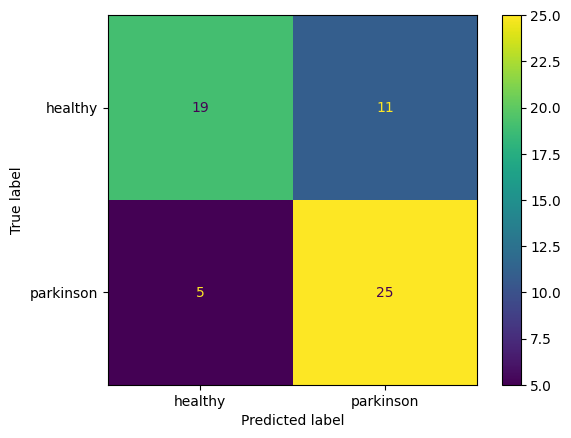

In [ ]:
modelResNet.load_weights('best_model.h5')
evaluate_dl_model(modelResNet, name, X_pd_test, y_pd_test, labels)

In [ ]:
modelResNet.load_weights('resnet.h5')

### Resized RGB

Epoch 1/30
29/29 [==============================] - ETA: 0s - loss: 2.2327 - accuracy: 0.3366
Epoch 1: val_accuracy improved from -inf to 0.51082, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 5s 182ms/step - loss: 2.2327 - accuracy: 0.3366 - val_loss: 3.2612 - val_accuracy: 0.5108
Epoch 2/30
29/29 [==============================] - ETA: 0s - loss: 1.3055 - accuracy: 0.5820
Epoch 2: val_accuracy did not improve from 0.51082
29/29 [==============================] - 5s 159ms/step - loss: 1.3055 - accuracy: 0.5820 - val_loss: 1.7020 - val_accuracy: 0.5108
Epoch 3/30
29/29 [==============================] - ETA: 0s - loss: 0.7866 - accuracy: 0.6710
Epoch 3: val_accuracy did not improve from 0.51082
29/29 [==============================] - 5s 158ms/step - loss: 0.7866 - accuracy: 0.6710 - val_loss: 1.4018 - val_accuracy: 0.5108
Epoch 4/30
29/29 [==============================] - ETA: 0s - loss: 0.6763 - accuracy: 0.6786
Epoch 4: val_accuracy did not improve from 0.51082
29/29 [==============================] - 5s 161ms/step - loss: 0.6763 - accuracy: 0.6786 - val_loss: 1.5888 - val_accuracy: 0.5108
Epoch 5/30
29/29 [=======================

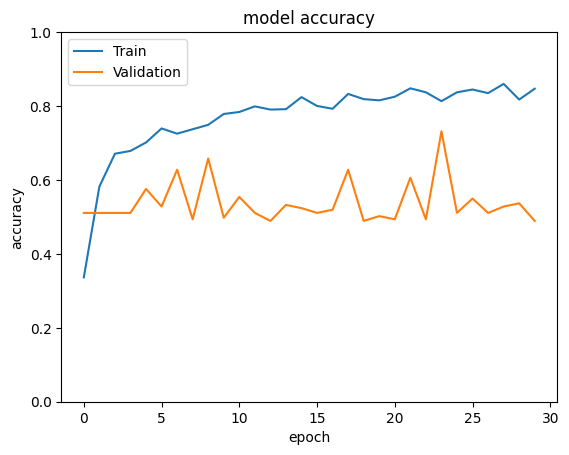

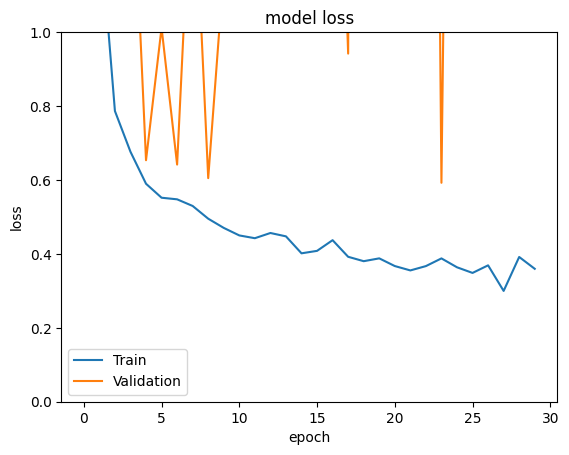

In [ ]:
train_dl_model(modelResNet, name, X_rs_train, y_rs_train)

2/2 [==============================] - 0s 104ms/step - loss: 0.5325 - accuracy: 0.7667
ResNet Test Accuracy: 0.7667, ResNet Test Loss: 0.5325

2/2 [==============================] - 0s 104ms/step

Classification Report do ResNet
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        30
           1       0.90      0.60      0.72        30

    accuracy                           0.77        60
   macro avg       0.80      0.77      0.76        60
weighted avg       0.80      0.77      0.76        60


TPR por classe do ResNet: [0.9333 0.6   ]

Confusion Matrix


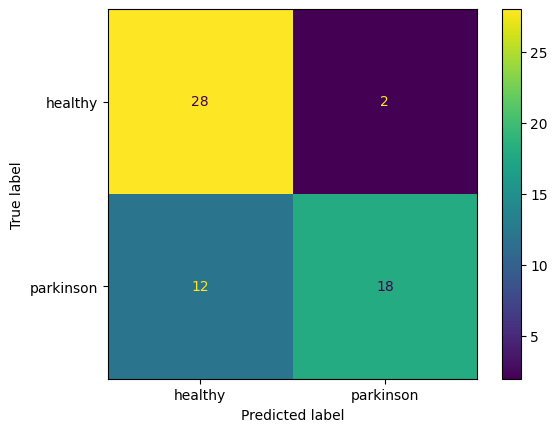

In [ ]:
modelResNet.load_weights('best_model.h5')
evaluate_dl_model(modelResNet, name, X_rs_test, y_rs_test, labels)

In [ ]:
modelResNet.load_weights('resnet.h5')

### Segmented

Epoch 1/30
29/29 [==============================] - ETA: 0s - loss: 1.8289 - accuracy: 0.5309
Epoch 1: val_accuracy improved from -inf to 0.47619, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 6s 191ms/step - loss: 1.8289 - accuracy: 0.5309 - val_loss: 3.1200 - val_accuracy: 0.4762
Epoch 2/30
29/29 [==============================] - ETA: 0s - loss: 0.9954 - accuracy: 0.7557
Epoch 2: val_accuracy improved from 0.47619 to 0.75325, saving model to best_model.h5
29/29 [==============================] - 5s 179ms/step - loss: 0.9954 - accuracy: 0.7557 - val_loss: 0.8853 - val_accuracy: 0.7532
Epoch 3/30
29/29 [==============================] - ETA: 0s - loss: 0.7136 - accuracy: 0.7774
Epoch 3: val_accuracy improved from 0.75325 to 0.76190, saving model to best_model.h5
29/29 [==============================] - 5s 164ms/step - loss: 0.7136 - accuracy: 0.7774 - val_loss: 0.5926 - val_accuracy: 0.7619
Epoch 4/30
29/29 [==============================] - ETA: 0s - loss: 0.5318 - accuracy: 0.8295
Epoch 4: val_accuracy did not improve from 0.76190
29/29 [==============================] - 4s 149ms/step - loss: 0.5318 - accuracy: 0.8295 - val_loss: 0

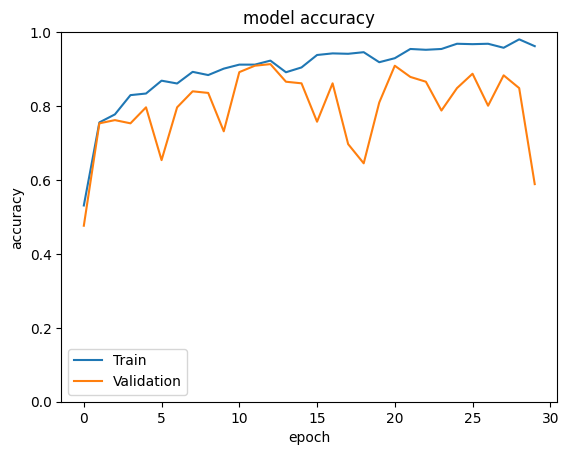

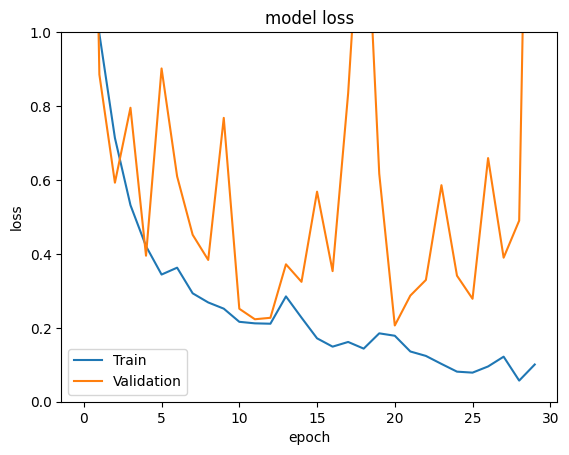

In [ ]:
train_dl_model(modelResNet, name, X_seg_train, y_seg_train)

2/2 [==============================] - 0s 131ms/step - loss: 0.6256 - accuracy: 0.7167
ResNet Test Accuracy: 0.7167, ResNet Test Loss: 0.6256

2/2 [==============================] - 0s 107ms/step

Classification Report do ResNet
              precision    recall  f1-score   support

           0       0.71      0.73      0.72        30
           1       0.72      0.70      0.71        30

    accuracy                           0.72        60
   macro avg       0.72      0.72      0.72        60
weighted avg       0.72      0.72      0.72        60


TPR por classe do ResNet: [0.7333 0.7   ]

Confusion Matrix


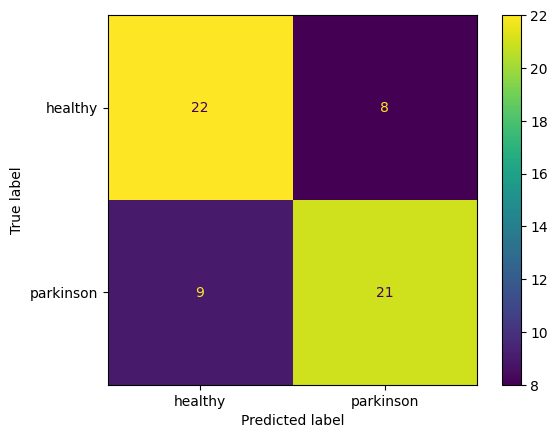

In [ ]:
modelResNet.load_weights('best_model.h5')
evaluate_dl_model(modelResNet, name, X_seg_test, y_seg_test, labels)

In [ ]:
modelResNet.load_weights('resnet.h5')

#VGG


In [ ]:
name = "VGG"


# Configurando o modelo base VGG16 com pesos pré-treinados
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # Congelar a base do modelo

# Construção do novo modelo para o novo conjunto de classes
modelVGG = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # adaptar o número de classes conforme necessário
])

# Compilar o modelo com as configurações de otimização e perda
modelVGG.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
modelVGG.save_weights('vgg16.h5')

58889256/58889256 [==============================] - 0s 0us/step


## Inference

### Padded RGB

Epoch 1/30
29/29 [==============================] - ETA: 0s - loss: 3.9279 - accuracy: 0.5668
Epoch 1: val_accuracy improved from -inf to 0.75325, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 24s 516ms/step - loss: 3.9279 - accuracy: 0.5668 - val_loss: 0.6986 - val_accuracy: 0.7532
Epoch 2/30
29/29 [==============================] - ETA: 0s - loss: 1.4443 - accuracy: 0.7014
Epoch 2: val_accuracy improved from 0.75325 to 0.84416, saving model to best_model.h5
29/29 [==============================] - 11s 374ms/step - loss: 1.4443 - accuracy: 0.7014 - val_loss: 0.4143 - val_accuracy: 0.8442
Epoch 3/30
29/29 [==============================] - ETA: 0s - loss: 0.5315 - accuracy: 0.7904
Epoch 3: val_accuracy did not improve from 0.84416
29/29 [==============================] - 5s 187ms/step - loss: 0.5315 - accuracy: 0.7904 - val_loss: 0.3764 - val_accuracy: 0.8052
Epoch 4/30
29/29 [==============================] - ETA: 0s - loss: 0.4583 - accuracy: 0.8056
Epoch 4: val_accuracy did not improve from 0.84416
29/29 [==============================] - 6s 195ms/step - loss: 0.4583 - accuracy: 0.8056 - val_loss: 0.3489 - val_accuracy: 0.8398
Epoc

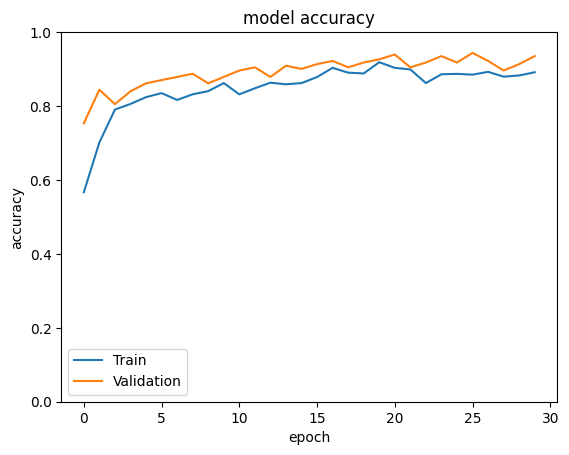

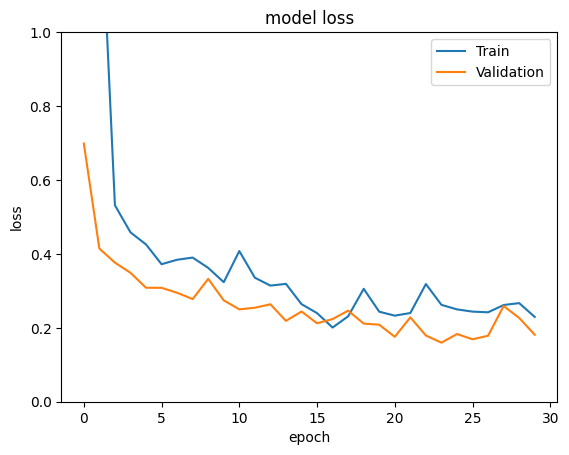

In [ ]:
train_dl_model(modelVGG, name, X_pd_train, y_pd_train)

2/2 [==============================] - 7s 7s/step - loss: 0.5183 - accuracy: 0.8333
VGG Test Accuracy: 0.8333, VGG Test Loss: 0.5183

2/2 [==============================] - 0s 144ms/step

Classification Report do VGG
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        30
           1       0.81      0.87      0.84        30

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.83        60


TPR por classe do VGG: [0.8    0.8667]

Confusion Matrix


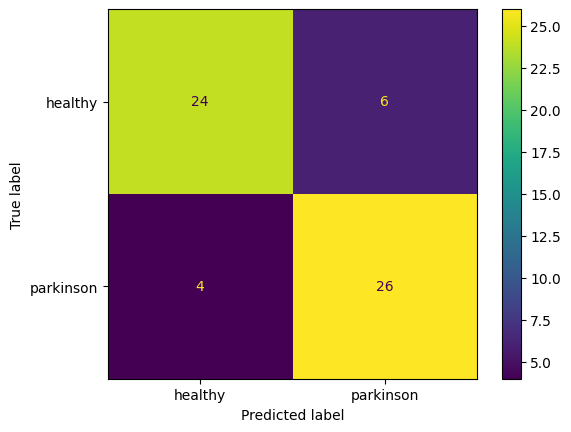

In [ ]:
modelVGG.load_weights('best_model.h5')
evaluate_dl_model(modelVGG, name, X_pd_test, y_pd_test, labels)

In [ ]:
modelVGG.load_weights('vgg16.h5')

### Resized RGB

Epoch 1/30
29/29 [==============================] - ETA: 0s - loss: 5.7716 - accuracy: 0.5603
Epoch 1: val_accuracy improved from -inf to 0.53247, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 35s 1s/step - loss: 5.7716 - accuracy: 0.5603 - val_loss: 1.6292 - val_accuracy: 0.5325
Epoch 2/30
29/29 [==============================] - ETA: 0s - loss: 0.8451 - accuracy: 0.7090
Epoch 2: val_accuracy improved from 0.53247 to 0.86580, saving model to best_model.h5
29/29 [==============================] - 18s 649ms/step - loss: 0.8451 - accuracy: 0.7090 - val_loss: 0.4128 - val_accuracy: 0.8658
Epoch 3/30
29/29 [==============================] - ETA: 0s - loss: 0.5245 - accuracy: 0.7622
Epoch 3: val_accuracy did not improve from 0.86580
29/29 [==============================] - 6s 200ms/step - loss: 0.5245 - accuracy: 0.7622 - val_loss: 0.3684 - val_accuracy: 0.8485
Epoch 4/30
29/29 [==============================] - ETA: 0s - loss: 0.5275 - accuracy: 0.7611
Epoch 4: val_accuracy did not improve from 0.86580
29/29 [==============================] - 6s 199ms/step - loss: 0.5275 - accuracy: 0.7611 - val_loss: 0.4156 - val_accuracy: 0.7965
Epoch 5

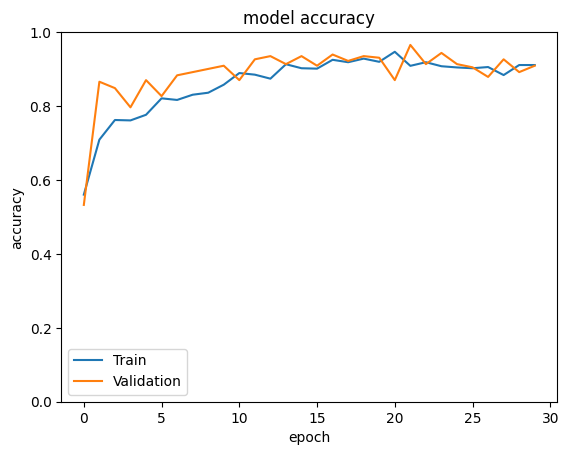

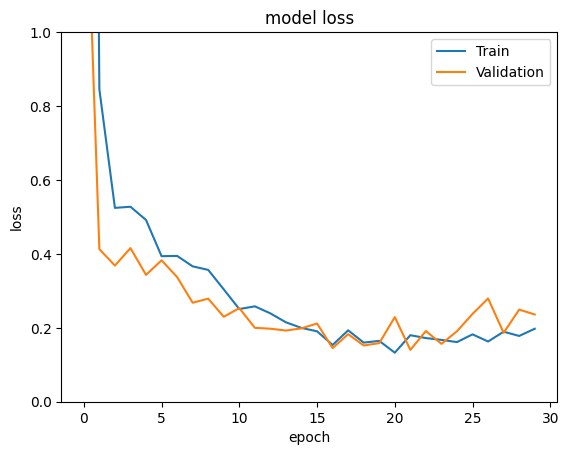

In [ ]:
train_dl_model(modelVGG, name, X_rs_train, y_rs_train)

2/2 [==============================] - 0s 172ms/step - loss: 0.4854 - accuracy: 0.8500
VGG Test Accuracy: 0.85, VGG Test Loss: 0.4854

2/2 [==============================] - 0s 150ms/step

Classification Report do VGG
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        30
           1       0.82      0.90      0.86        30

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60


TPR por classe do VGG: [0.8 0.9]

Confusion Matrix


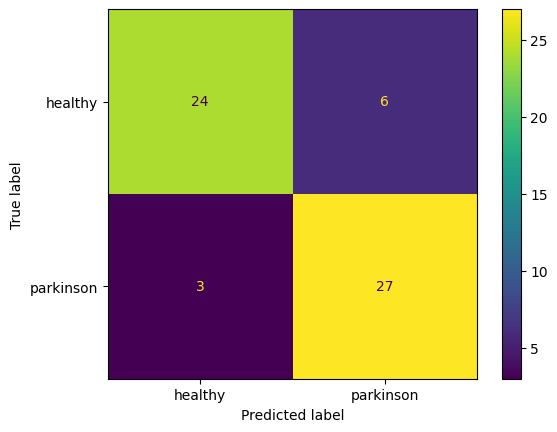

In [ ]:
modelVGG.load_weights('best_model.h5')
evaluate_dl_model(modelVGG, name, X_rs_test, y_rs_test, labels)

In [ ]:
modelVGG.load_weights('vgg16.h5')

### Segmented

Epoch 1/30
29/29 [==============================] - ETA: 0s - loss: 5.7643 - accuracy: 0.5689
Epoch 1: val_accuracy improved from -inf to 0.75758, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 14s 498ms/step - loss: 5.7643 - accuracy: 0.5689 - val_loss: 0.7637 - val_accuracy: 0.7576
Epoch 2/30
29/29 [==============================] - ETA: 0s - loss: 1.2801 - accuracy: 0.7068
Epoch 2: val_accuracy improved from 0.75758 to 0.84416, saving model to best_model.h5
29/29 [==============================] - 20s 697ms/step - loss: 1.2801 - accuracy: 0.7068 - val_loss: 0.3832 - val_accuracy: 0.8442
Epoch 3/30
29/29 [==============================] - ETA: 0s - loss: 0.5057 - accuracy: 0.7991
Epoch 3: val_accuracy improved from 0.84416 to 0.84848, saving model to best_model.h5
29/29 [==============================] - 25s 896ms/step - loss: 0.5057 - accuracy: 0.7991 - val_loss: 0.3335 - val_accuracy: 0.8485
Epoch 4/30
29/29 [==============================] - ETA: 0s - loss: 0.4298 - accuracy: 0.8263
Epoch 4: val_accuracy improved from 0.84848 to 0.87879, saving model to best_model.h5
29/29 [==============================] - 23s 797ms/step - loss: 

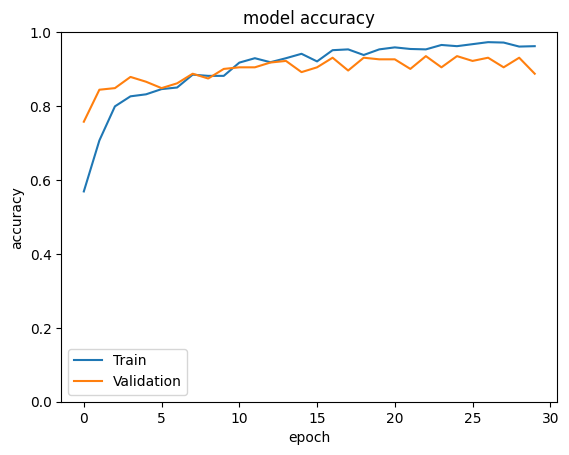

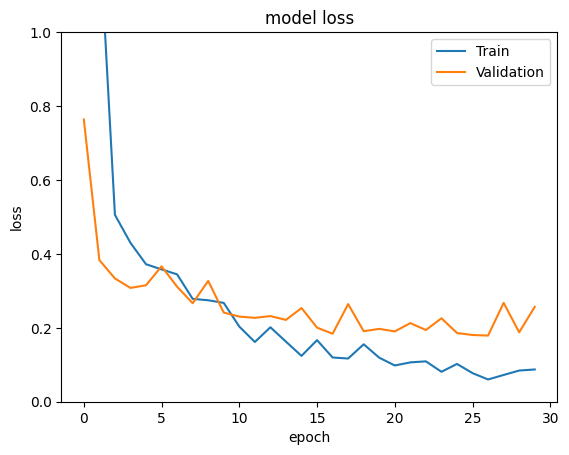

In [ ]:
train_dl_model(modelVGG, name, X_seg_train, y_seg_train)

2/2 [==============================] - 0s 144ms/step - loss: 0.7544 - accuracy: 0.8167
VGG Test Accuracy: 0.8167, VGG Test Loss: 0.7544

2/2 [==============================] - 0s 141ms/step

Classification Report do VGG
              precision    recall  f1-score   support

           0       0.83      0.80      0.81        30
           1       0.81      0.83      0.82        30

    accuracy                           0.82        60
   macro avg       0.82      0.82      0.82        60
weighted avg       0.82      0.82      0.82        60


TPR por classe do VGG: [0.8    0.8333]

Confusion Matrix


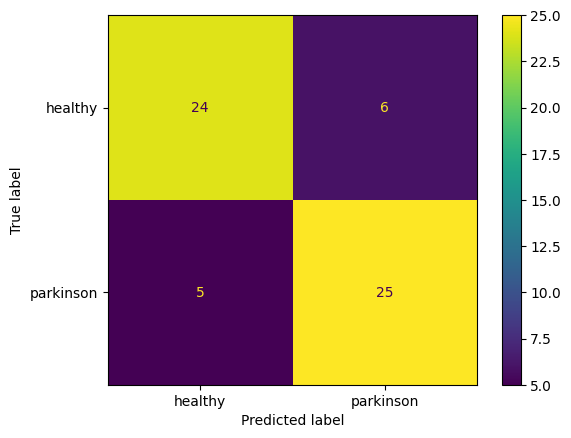

In [ ]:
modelVGG.load_weights('best_model.h5')
evaluate_dl_model(modelVGG, name, X_seg_test, y_seg_test, labels)

In [ ]:
modelVGG.load_weights('vgg16.h5')